# WGCNA
weighted gene co-expression network analysis

# Phase 2 vs. Phase 2

## 0. load libraries

In [80]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)
library(hrbrthemes)

ERROR: Error in library(reshape): there is no package called ‘reshape’


## 1. read and format CSVs

### counts

In [63]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts <- counts %>%
select(-Gene_ID, -Length)

head(counts)

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,2,1,6,10,9,16,0,10,22,9,⋯,9,2,8,5,2,19,1,2,1,0
LOC111126949,885,652,477,654,586,523,392,357,496,540,⋯,407,740,707,406,418,424,492,330,281,599
LOC111110729,64,209,93,63,100,177,76,98,235,181,⋯,70,149,121,115,126,108,118,115,127,213
LOC111112434,11,7,2,0,2,2,12,15,10,36,⋯,11,6,4,0,2,16,22,0,8,0
LOC111120752,360,586,336,426,351,417,236,278,761,373,⋯,359,345,438,278,287,416,621,251,333,430
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


### meta data

In [49]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

head(meta)
dim(meta)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4
B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3


[1] 96  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [50]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both both
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both warm


,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
W6_W3_G36,warm,warm,normoxic,6,warm,warm,normoxic,3,warm warm
W6_W4_G48,warm,warm,normoxic,6,warm,warm,normoxic,4,warm warm


In [65]:
# setting the same order for counts matrix and meta data
counts <- counts[,rownames(meta)]
all(rownames(meta) == colnames(counts))

[1] TRUE

## 2. run DESeq

running with design ~1 bc we just need a dds object to transform

In [66]:
dds <- DESeqDataSetFromMatrix(countData = counts,
                          colData = meta,
                          design = ~1)

In [69]:
# transform the data
dds_vst <- vst(dds)
# create matrix and transpose
dds_vst <- t(assay(dds_vst))
head(dds_vst)

,LOC111116054,LOC111126949,LOC111110729,LOC111112434,LOC111120752,LOC111128944,LOC111128953,LOC111105691,LOC111105685,LOC111105702,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
B1_B1_O01,7.834772,10.235447,8.462818,8.018169,9.427713,7.69804,7.698040,7.834772,7.69804,7.69804,⋯,18.94136,17.34955,16.72141,16.54692,17.39682,17.49895,15.26840,14.40581,17.08007,13.21036
B1_W5_O50,7.941460,9.705184,8.640668,7.838690,9.418093,7.69804,7.698040,7.979007,7.69804,7.69804,⋯,19.24123,17.59103,17.04619,16.53569,16.96737,17.29194,15.58826,14.95019,17.20573,13.41318
B2_B5_O51,8.004370,9.945688,8.459499,7.698040,9.567589,7.69804,7.698040,8.691547,7.69804,7.69804,⋯,19.41212,17.93599,17.26468,17.22822,17.78664,18.11063,15.97887,15.63600,17.73442,13.77079
B2_C4_O40,7.976745,9.768217,8.613087,7.829582,9.349592,7.69804,7.698040,8.221513,7.69804,7.69804,⋯,18.85576,17.78861,17.26273,16.60839,17.18518,17.18279,15.13820,14.82530,17.00082,13.10698
B3_B4_O41,7.698040,9.666535,8.617954,8.068780,9.268062,7.69804,7.698040,8.138807,7.69804,7.69804,⋯,19.70614,18.16136,17.53962,17.10812,17.48265,17.96771,15.70444,15.28128,17.70839,13.86743
B3_C3_O30,8.039331,9.601008,8.745766,8.115551,9.401098,7.69804,7.850954,8.266771,7.69804,7.69804,⋯,19.26295,17.86728,17.63850,17.07130,17.28802,17.12602,15.57887,15.13249,17.13229,13.28483


## 2. run WCGNA

following this [tutorial](https://bioinformaticsworkbook.org/tutorials/wgcna.html#gsc.tab=0)

for WCGNA, `rows = treatments` and `columns = gene IDs`

In [70]:
# check data for WCGNA (built-in function)
gsg <- goodSamplesGenes(dds_vst, verbose = 3)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 3426 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

In [71]:
# removing flagged genes, subsetting with flags WCGNA returned
dds_vst_gsg <- dds_vst[gsg$goodSamples, gsg$goodGenes]

# checking again
gsg2 <- goodSamplesGenes(dds_vst_gsg, verbose = 3)
gsg2$allOK


 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

In [84]:
# determine outlier samples 
sampleTree = hclust(dist(dds_vst_gsg), method = "average") # Next we cluster the samples (in contrast to clustering genes that will come later)  to see if there are any obvious outliers.
sizeGrWindow(12,9) # The user should change the dimensions if the window is too large or too small.
par(cex = 0.6);
par(mar = c(0,4,2,0))


png("/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/plots/ClusterTree_Precut.png", 2000, 1000, pointsize=20)
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5, 
     cex.axis = 1.5, cex.main = 2) # appears there are two outliers SG55 and SG 105; can remove by hand or an automatic appraoch 
abline(h = 110, col = "red") # add line to plot to show the cut-off od outlier samples (40000) SG105 and SG55
dev.off()


png 
  2

looks like maybe B4_H1_O07 might be an outlier but going to keep in right now 

In [92]:
meta$Sample.names <- row.names(meta)

head(meta)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt,Sample.names
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both both,B1_B1_O01
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both warm,B1_W5_O50
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5,both both,B2_B5_O51
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4,both control,B2_C4_O40
B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4,both both,B3_B4_O41
B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3,both control,B3_C3_O30


In [93]:
# Form a data frame analogous to expression data that will hold the clinical traits.
p2.Samples = rownames(dds_vst_gsg);# start new variable 'p2.Samples' calling the row names of the gene data (sample as 'Mouse' in trait data)
TreatRows = match(p2.Samples, meta$Sample.names); # match the names 

head(p2.Samples)
head(TreatRows)

[1] "B1_B1_O01" "B1_W5_O50" "B2_B5_O51" "B2_C4_O40" "B3_B4_O41" "B3_C3_O30"

[1] 1 2 3 4 5 6

In [94]:
p2.Traits = meta[TreatRows, -1]; # removes the row numbers
rownames(p2.Traits) = meta[TreatRows, 1]; # inserts the new traitRows - matches sample treatments


Warning message:
“non-unique values when setting 'row.names': ‘both’, ‘control’, ‘hypoxic’, ‘warm’”


ERROR: Error in `.rowNamesDF<-`(x, value = value): duplicate 'row.names' are not allowed


In [ ]:
dim(p2.Traits) #  8 Samples 2 columns (primary and second treatment) - note: no Third treatment because that occured Days 14-21, after this sampling day
all(rownames(p2.Traits) == rownames(dds_vst_gsg))  # should be TRUE
dim(p2.Traits) #  8 2

### picking a threshold value
WGCNA will try a range of soft thresholds and create a diagnostic plot

In [28]:
allowWGCNAThreads() # allow multi-threading 

Allowing multi-threading with up to 24 threads.


In [29]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))

In [45]:
# Call the network topology analysis function
sft = pickSoftThreshold(
  input_data,            
  #blockSize = 30,
  powerVector = powers,
  verbose = 5
  )

pickSoftThreshold: will use block size 1263.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1263 of 35412
   ..working on genes 1264 through 2526 of 35412
   ..working on genes 2527 through 3789 of 35412
   ..working on genes 3790 through 5052 of 35412
   ..working on genes 5053 through 6315 of 35412
   ..working on genes 6316 through 7578 of 35412
   ..working on genes 7579 through 8841 of 35412
   ..working on genes 8842 through 10104 of 35412
   ..working on genes 10105 through 11367 of 35412
   ..working on genes 11368 through 12630 of 35412
   ..working on genes 12631 through 13893 of 35412
   ..working on genes 13894 through 15156 of 35412
   ..working on genes 15157 through 16419 of 35412
   ..working on genes 16420 through 17682 of 35412
   ..working on genes 17683 through 18945 of 35412
   ..working on genes 18946 through 20208 of 35412
   ..working on genes 20209 through 21471 of 35412
   ..working on genes 21472 through 22734

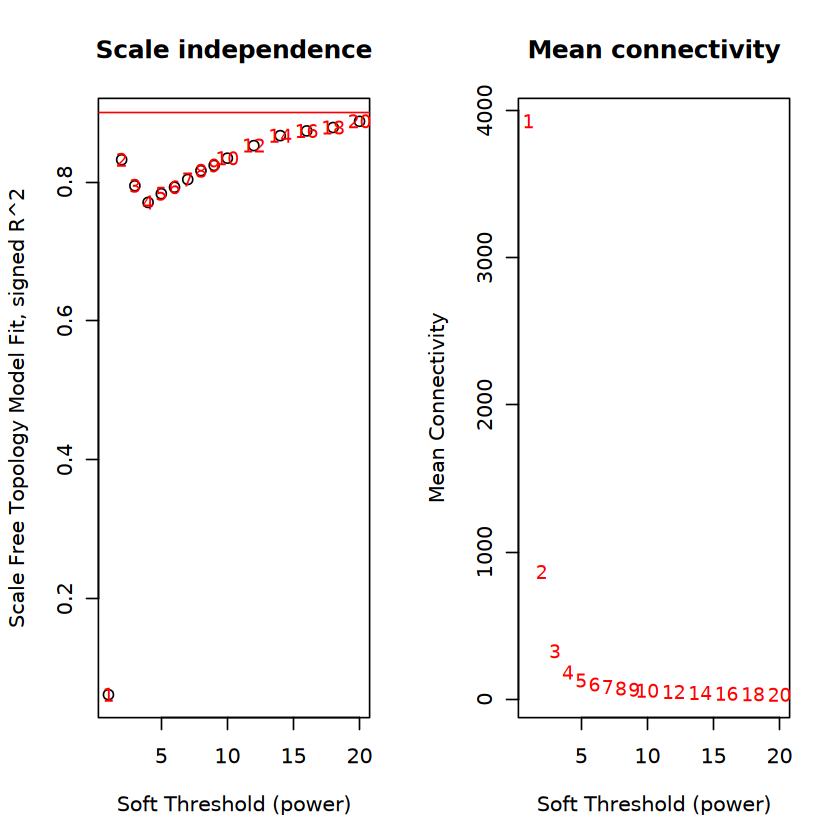

In [46]:
par(mfrow = c(1,2));
cex1 = 0.9;

plot(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Soft Threshold (power)",
     ylab = "Scale Free Topology Model Fit, signed R^2",
     main = paste("Scale independence")
)
text(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red"
)
abline(h = 0.90, col = "red")
plot(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     xlab = "Soft Threshold (power)",
     ylab = "Mean Connectivity",
     type = "n",
     main = paste("Mean connectivity")
)
text(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     labels = powers,
     cex = cex1, col = "red")

picking soft threshold power of 9, since it is near the curve

now running WGCNA

In [47]:
picked_power = 9
temp_cor <- cor       
cor <- WGCNA::cor         # Force it to use WGCNA cor function (fix a namespace conflict issue)
netwk <- blockwiseModules(input_data,                # <= input here

                          # == Adjacency Function ==
                          power = picked_power,                # <= power here
                          networkType = "signed",

                          # == Tree and Block Options ==
                          deepSplit = 2,
                          pamRespectsDendro = F,
                          # detectCutHeight = 0.75,
                          minModuleSize = 30,
                          maxBlockSize = 4000,

                          # == Module Adjustments ==
                          reassignThreshold = 0,
                          mergeCutHeight = 0.25,

                          # == TOM == Archive the run results in TOM file (saves time)
                          saveTOMs = T,
                          saveTOMFileBase = "ER",

                          # == Output Options
                          numericLabels = T,
                          verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3    4    5    6    7    8    9   10 
4000 3994 3987 3945 3939 3864 3820 3673 3616  574 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 24 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ER-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 110 genes from module 1 because their KME is too low.
     ..removing 247 genes from module 2 because their KME is too low.
 ..Working on block 2 .
    TOM calculation: adjacency..
    ..will use 

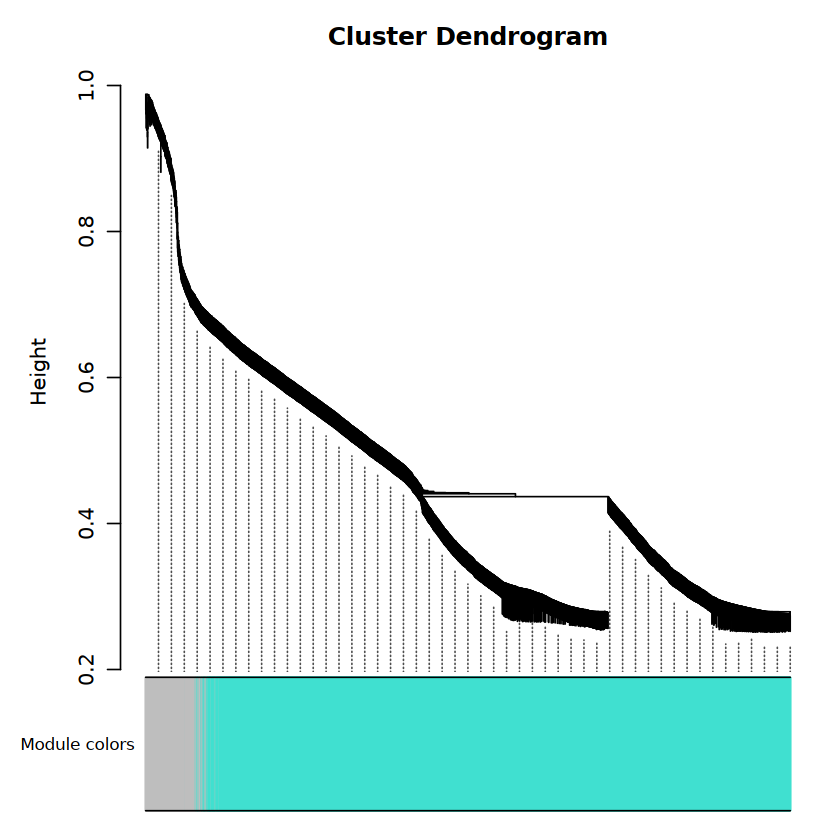

In [48]:
# Convert labels to colors for plotting
mergedColors = labels2colors(netwk$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(
  netwk$dendrograms[[1]],
  mergedColors[netwk$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )